# Workshop 5 – Vector Data Fundamentals in Python  
**Programación SIG**   
2025-1
Lecturer: Liliana Castillo Villamor

## 1. Learning objectives  
After completing this workshop you will be able to  

1. Describe `GeoDataFrame`, `GeoSeries`, and **Shapely** geometries.  
2. Inspect, measure, and transform vector data in a metric CRS.  
3. Manipulate attributes with pandas/GeoPandas (selection, aggregation, joins).  
4. Join a non‑spatial agricultural table to a spatial layer.  
5. Dissolve polygons to summarise at regional level.  
6. Produce publication‑ready maps in Python.

*All text uses British English spelling.*  


---

## 2.  Setting the scene

### 2.1. **Import** the core libraries.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
from pathlib import Path
from matplotlib.colors import Normalize

### 2.2. Define data paths, and read the municipal shapefile and agricultural CSV.


| Step | What happens? | Key function / property |
|------|---------------|-------------------------|
| **1&nbsp;️&nbsp;Define `root_folder`** | Sets a *base directory* that stores all the workshop material on your computer. Change this string if your files live elsewhere. | *Plain Python string* |
| **2&nbsp;️&nbsp;Build file paths** – `shp_path`, `csv_path` | Concatenates the base directory with each filename. The **raw-string prefix `r"…"``** avoids back-slash issues under Windows. | String concatenation |
| **3&nbsp;️&nbsp;Read the shapefile** – `df_municipios = gpd.read_file(shp_path)` | Loads **`municipios_colombia.shp`** (plus its `.dbf`, `.shx`, `.prj` companions) into a GeoDataFrame. | `geopandas.read_file()` |
| **4&nbsp;️&nbsp;Create a second GeoDataFrame `muni`** | Re-opens the same shapefile so we can keep an untouched copy or experiment independently. | `geopandas.read_file()` |
| **5&nbsp;️&nbsp;Print the CRS** – `print("CRS:", muni.crs)` | Confirms the layer’s Coordinate Reference System. It should report **EPSG 3116 – MAGNA-SIRGAS / Colombia Bogotá** (units: metres). | `GeoDataFrame.crs` |
| **6&nbsp;️&nbsp;Inspect the schema** – `muni.info()` | Shows a tidy summary: number of rows, data types, and non-null counts for every column. Useful for quick QA. | `GeoDataFrame.info()` |
| **7&nbsp&nbsp;Preview the first rows** – `muni.head()` | Prints the first five records so you can spot-check attribute names and typical values. | `GeoDataFrame.head()` |

> **Note:** The path for the EVA table (`csv_path`) is defined here but **not** read yet—we will load it later when demonstrating attribute joins.

If you encounter “file not found” errors, double-check that **`root_folder`** reflects the actual folder structure on *your* machine and that filenames (including capitalisation) are correct.

In [2]:
root_folder=r"/notebooks/datos/geodata_spatoper"
''' root_folder="/notebooks/datos" '''

shp_path=root_folder+r"/municipios_colombia.shp"
df_municipios = gpd.read_file(shp_path)
csv_path  = root_folder+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"
stations_csv_path=root_folder+"/Catalogo_Estaciones_IDEAM.csv"
muni = gpd.read_file(shp_path)
print("CRS:", muni.crs)              
muni.info()
print(muni.head())

CRS: EPSG:3116
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1122 non-null   object  
 1   MPIO_CCDGO  1122 non-null   object  
 2   MPIO_CNMBR  1122 non-null   object  
 3   MPIO_CDPMP  1122 non-null   object  
 4   VERSION     1122 non-null   int32   
 5   AREA        1122 non-null   float64 
 6   LATITUD     1122 non-null   float64 
 7   LONGITUD    1122 non-null   float64 
 8   STCTNENCUE  1122 non-null   float64 
 9   STP3_1_SI   1122 non-null   float64 
 10  STP3_2_NO   1122 non-null   float64 
 11  STP3A_RI    1122 non-null   float64 
 12  STP3B_TCN   1122 non-null   float64 
 13  STP4_1_SI   1122 non-null   float64 
 14  STP4_2_NO   1122 non-null   float64 
 15  STP9_1_USO  1122 non-null   float64 
 16  STP9_2_USO  1122 non-null   float64 
 17  STP9_3_USO  1122 non-null   float64 
 18  STP9_4_USO  1122 non-null

The municipality layer follows the Marco Geoestadístico Nacional – MGN 2018 schema published by DANE.
A full description of every attribute appears in the official manual “MGN 2018 integrado con CNPV 2018 – Instructivo de Uso” (DANE 2020). You can find the document in the course data folder. The file is called "MGN2018_Integrado_CNPV2018_InstructivoUso.pdf".



## 3  GeoDataFrame anatomy  

`muni` is a **GeoDataFrame** – essentially a pandas DataFrame plus a special *geometry* column (a **GeoSeries**) containing Shapely objects. The next cell inspects their classes and geometry types.


A **GeoSeries** is the spatial cousin of a pandas *Series*: a one-dimensional array whose elements are **Shapely** geometry objects (e.g. `Point`, `LineString`, `Polygon`).  
Each geometry can be written or read as **WKT** (*Well-Known Text*), a plain-text OGC standard such as `POINT (-74.08 4.60)`; Shapely converts seamlessly between WKT strings and live objects.

A **GeoDataFrame** extends a pandas *DataFrame* by declaring one special column—usually called `geometry`—to hold that GeoSeries of Shapely objects and by storing a `crs` attribute for the Coordinate Reference System.  
Because it “knows” which column is spatial, a GeoDataFrame unlocks GeoPandas functionality: mapping, reprojection, spatial joins, overlays, and more, while all other columns behave exactly like a regular DataFrame.

&nbsp;&nbsp;⇒ *DataFrame* = purely tabular.  
&nbsp;&nbsp;⇒ *GeoDataFrame* = tabular **plus** spatial context (geometry + CRS).

</div>
<div style="border-left:6px solid #20B2AA; padding:12px 16px; background:#f5fffa; border-radius:4px; font-size:95%;">

#### 🌐 What about the CRS?

A **GeoDataFrame** does **not** store its Coordinate Reference System as a separate column.  
Instead, the CRS lives in the object’s **`crs` attribute**, shared by every geometry in the `geometry` column.

* **`gdf.crs`** — returns (or prints) the current CRS, expressed either as an EPSG code or full PROJ string.  
* **`gdf.set_crs(<EPSG>, inplace=True)`** — assigns a CRS *when your data have none*, *without* altering coordinate values.  
* **`gdf.to_crs(<EPSG>)`** — re-projects the coordinates to a new CRS and returns a **new copy**; the original GeoDataFrame remains unchanged.



In [3]:
print(type(muni))
print(type(muni.geometry))
print(type(muni.geometry.iloc[0]))
muni.geom_type.unique()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.polygon.Polygon'>


array(['Polygon', 'MultiPolygon'], dtype=object)

### 3.1  Geometric attributes  

Because our CRS is metric, area and length are returned in square metres and metres.  

The municipal layer is already in **EPSG 3116**, a projected CRS whose linear unit is **metres**.  
That means:

* `muni.area` returns polygon area in **square metres**.  
* `muni.length` returns perimeter in **metres**.

In the next code cell we:

1. Convert area from m² to km² by dividing by `1 000 000` (`1e6`).  
2. Convert perimeter from m to km by dividing by `1 000` (`1e3`).  
3. Attach both derived measures as new columns (`area_km2`, `perim_km`).  

In [4]:
muni['area_km2'] = muni.area / 1e6
muni['perim_km'] = muni.length / 1e3
muni[['MPIO_CNMBR', 'area_km2', 'perim_km']].head()


,MPIO_CNMBR,area_km2,perim_km
0,FLORENCIA,2547.637532,326.343754
1,ALBANIA,414.122070,123.504054
2,BELÉN DE LOS ANDAQUÍES,1191.618572,247.957246
3,EL DONCELLO,1106.076151,349.761349
4,EL PAUJÍL,1234.734145,391.289839


### 3.1.1. Population density

The 2018 census variable **`STP27_PERS`** records the total number of inhabitants in each municipality.  
Dividing this figure by the municipal area in square kilometres (`area_km2`) yields **population density** expressed in *persons km⁻²*.

In the next code cell we:

1. Create a new column, `pop_density_p_km2`, with the formula  
   `STP27_PERS ÷ area_km2`.  
2. Extract a tidy two-column view—`MPIO_CNMBR` (municipality name) and the new density measure—so that we can inspect the first few results at a glance.

In [5]:
muni['pop_density_p_km2'] = muni['STP27_PERS'] / muni['area_km2']


muni_subset = muni[['MPIO_CNMBR', 'pop_density_p_km2']]

# Vista rápida de las primeras 5 filas, para eso sirve .head(), definir dentro del "()" un número n muestra esa cantidad de rows
muni_subset.head()


,MPIO_CNMBR,pop_density_p_km2
0,FLORENCIA,61.542899
1,ALBANIA,10.900168
2,BELÉN DE LOS ANDAQUÍES,7.615692
3,EL DONCELLO,16.070322
4,EL PAUJÍL,10.539921


### 3.2  First glimpse if spatial data 


### 3.1. Visualising the Most Populous Municipalities

In the following cell,you will identify and visualise the 20 most populous municipalities using the 2018 census data. The population figures are stored in the `STP27_PERS` column of the `muni` DataFrame.

1. First, we ensure that the population values are numeric. This is crucial because non-numeric entries (e.g., missing or malformed data) may cause errors during sorting or plotting. Any invalid entries are safely converted to `NaN` using `errors='coerce'`.

2.  We select two columns—`MPIO_CNMBR` (municipality name) and `STP27_PERS` (population)—and sort the DataFrame in descending order by population. We retain only the top 20 entries.

3.  We generate a horizontal bar chart to make it easier to compare population sizes visually. The chart is sorted from the smallest to the largest (bottom to top), which improves readability.

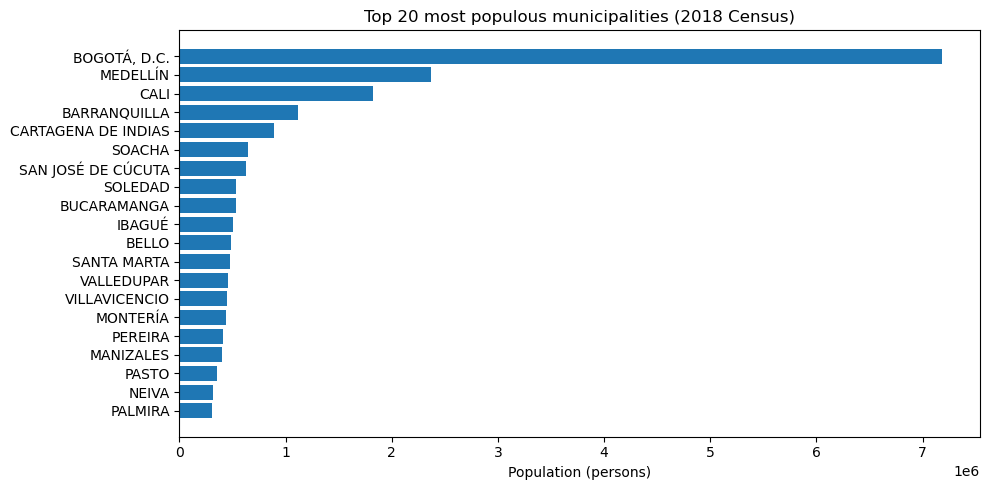

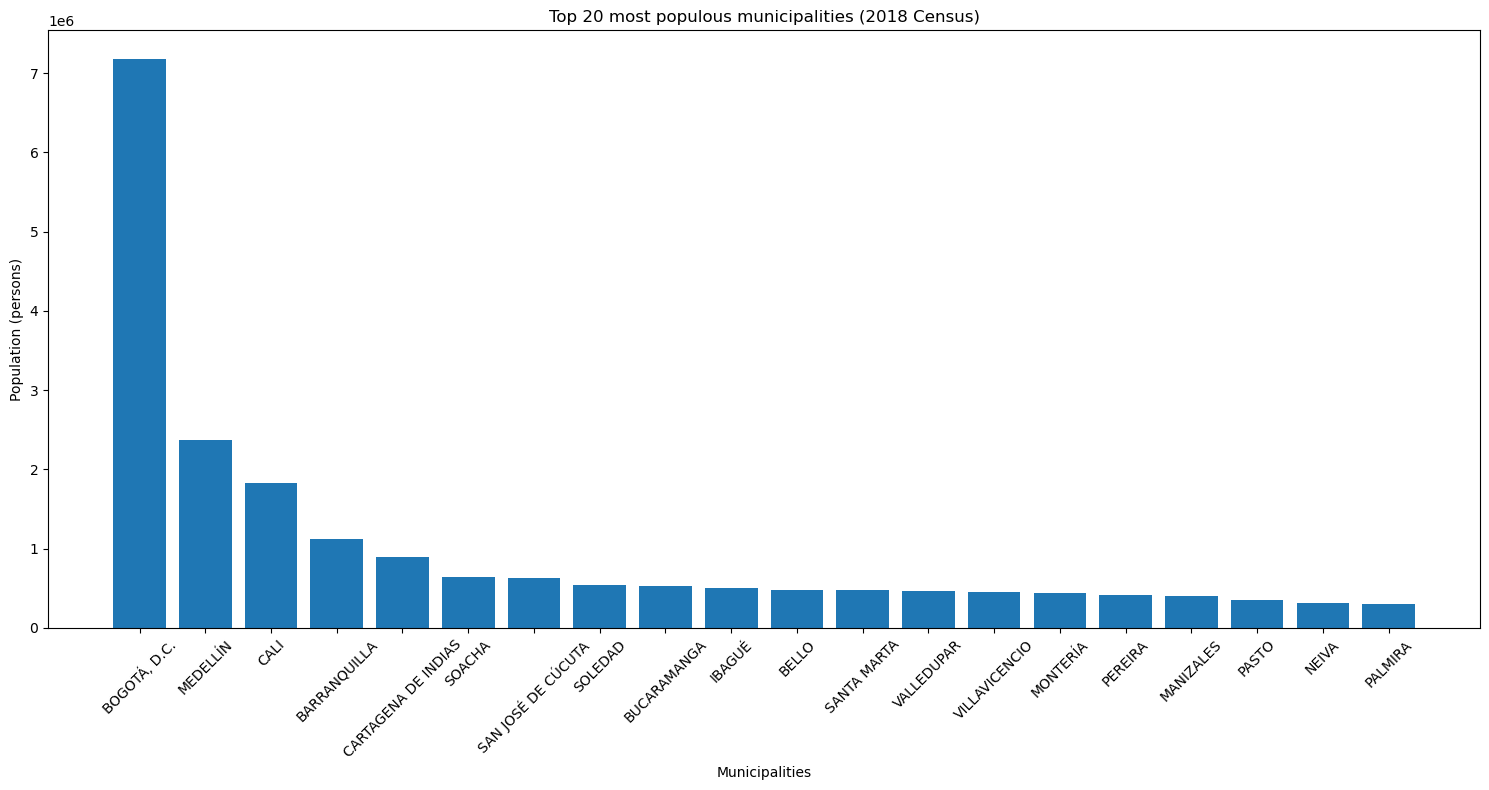

In [6]:
# Make sure the population field is numeric
muni['STP27_PERS'] = pd.to_numeric(muni['STP27_PERS'], errors='coerce')

# Select the 20 largest municipalities by population
top_pop = muni[['MPIO_CNMBR', 'STP27_PERS']]\
            .sort_values('STP27_PERS', ascending=False)\
            .head(20)

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(top_pop['MPIO_CNMBR'][::-1], top_pop['STP27_PERS'][::-1])
ax.set_xlabel('Population (persons)')
ax.set_title('Top 20 most populous municipalities (2018 Census)')
plt.tight_layout()
plt.show()

# Vertical bar chart
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(top_pop['MPIO_CNMBR'][::-1], top_pop['STP27_PERS'][::-1])
ax.set_xlabel('Municipalities')
ax.set_ylabel('Population (persons)')
ax.set_title('Top 20 most populous municipalities (2018 Census)')
ax.invert_xaxis()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 🔄 Now it’s your turn – Tabular visualisation practice

Using the same *muni* GeoDataFrame, experiment with the skills you have just seen:

1. **Least-populated municipalities**  
   *Create a horizontal bar chart of the 20 municipalities with the **lowest** population.  
   Hint*: sort `STP27_PERS` in ascending order.

2. **Population density ranking**  
   - Compute population density if you have not already:  
     `muni['pop_density_p_km2'] = muni['STP27_PERS'] / muni['area_km2']`.  
   - Plot the 20 most densely populated municipalities (persons km⁻²).

3. **Custom styling**  
   Re-plot one of your charts but:  
   * change the figure size to 12 × 7 inches,  
   * give the bars a semi-transparent teal fill (`alpha=0.7`), and  
   * add the exact values as data labels to the right of each bar.

4. **Interpretation challenge**  
   In a markdown cell, briefly answer:  
   *Which Colombian department contains the majority of the top-20 most densely populated municipalities and why might that be?*

Feel free to combine matplotlib techniques you already know—colours, axis inversion, annotations, etc.—to make the plots publication-ready.


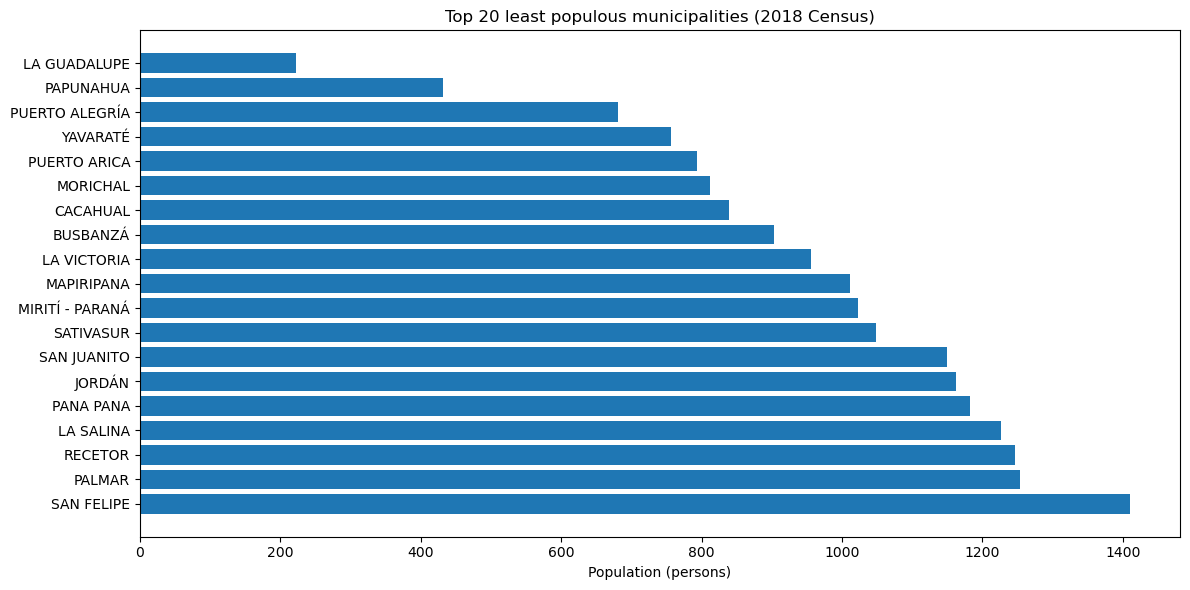

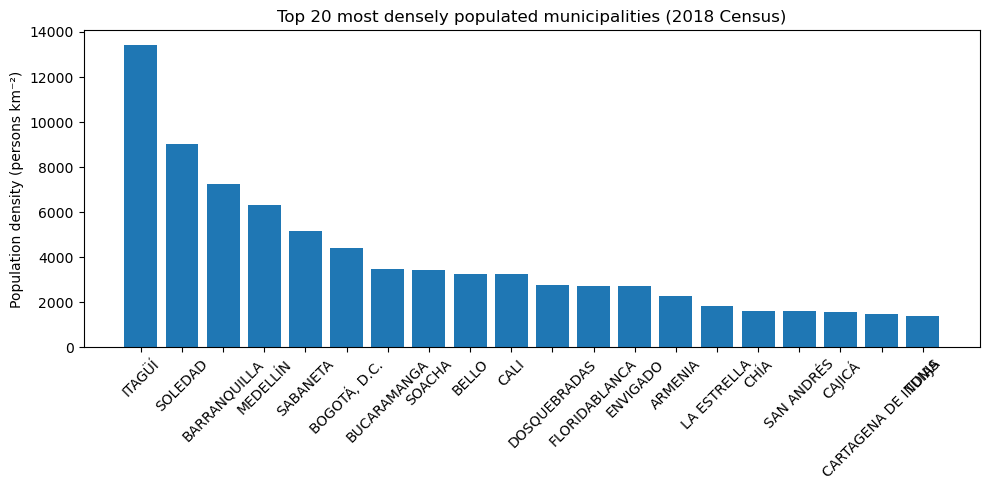

In [7]:
# Your script here

# 1. Least-Populated municipalities

# Nueva df con clasificación ascendente:

top_pop_asc = muni[['MPIO_CNMBR', 'STP27_PERS']].sort_values('STP27_PERS', ascending=True).head(20)

# Horizontal Bar de 20 municipios menos populares:

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_pop_asc['MPIO_CNMBR'][::-1], top_pop_asc['STP27_PERS'][::-1])
ax.set_xlabel('Population (persons)')
ax.set_title('Top 20 least populous municipalities (2018 Census)')
plt.tight_layout()
plt.show()

# 2. Plot de 20 municipios con mayor densidad:

top_dens_desc = muni[['MPIO_CNMBR', 'pop_density_p_km2']].sort_values('pop_density_p_km2', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top_dens_desc['MPIO_CNMBR'][::1], top_dens_desc['pop_density_p_km2'][::1])
ax.set_ylabel('Population density (persons km⁻²)')
ax.set_title('Top 20 most densely populated municipalities (2018 Census)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


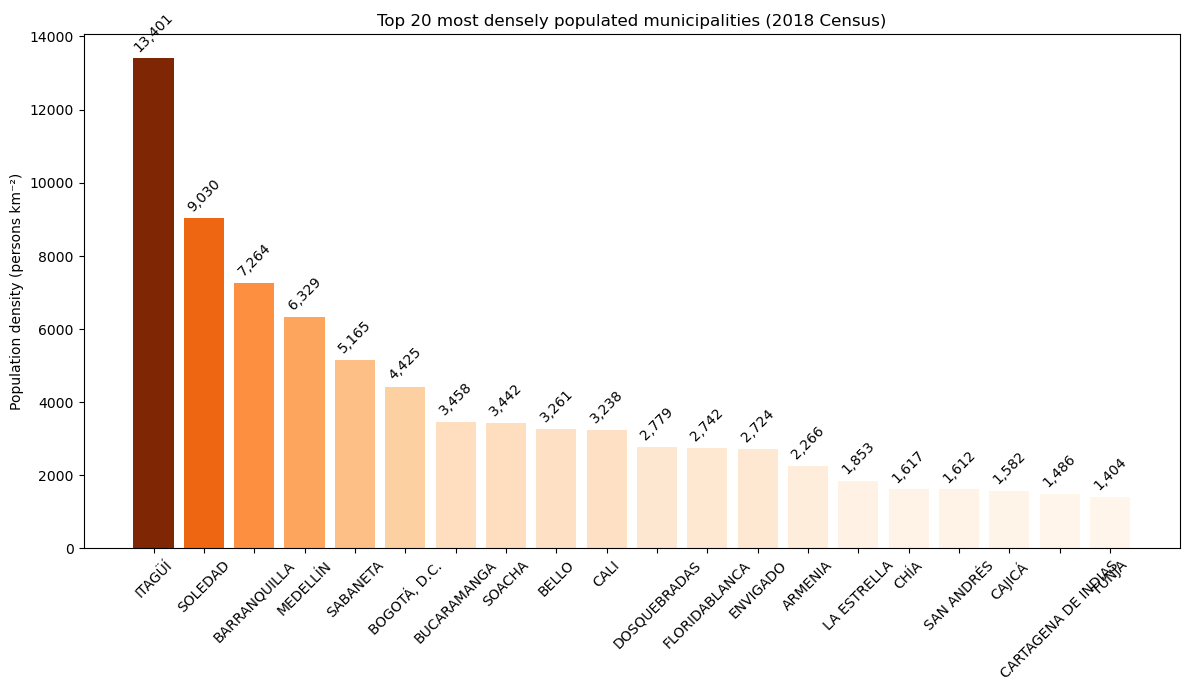

DPTO_CCDGO
05    6
25    3
08    2
68    2
11    1
76    1
66    1
63    1
88    1
13    1
15    1
Name: count, dtype: int64


In [13]:
# 3. Custom Styling: RePlot de Top 20 municipios con mayor densidad:

top_dens_desc = muni[['DPTO_CCDGO', 'MPIO_CNMBR', 'pop_density_p_km2']].sort_values('pop_density_p_km2', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 7))

# Normalizar valores para ponder degradado

norm_dens = Normalize(vmin=min(top_dens_desc['pop_density_p_km2']), vmax=max(top_dens_desc['pop_density_p_km2']))

cmap = plt.get_cmap('Oranges')

barsplot = ax.bar(top_dens_desc['MPIO_CNMBR'][::1], top_dens_desc['pop_density_p_km2'][::1], color=cmap(norm_dens(top_dens_desc['pop_density_p_km2'])))

# Etiquetas de valores en las barras
# Nota: IA dice que para versiones superiores a 3,7 de Matplotlib se define sin decimales y con miles como fmt='{:,.0f}', pero para anteriores se define de esta manera:

ax.bar_label(barsplot, labels=[f'{x:,.0f}' for x in top_dens_desc['pop_density_p_km2']], padding=3, rotation=45)

ax.set_ylabel('Population density (persons km⁻²)')
ax.set_title('Top 20 most densely populated municipalities (2018 Census)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

muni_dep = top_dens_desc['DPTO_CCDGO'].value_counts()
print(muni_dep)


4. **Interpretation challenge**  
   *Which Colombian department contains the majority of the top-20 most densely populated municipalities and why might that be?*
   
   *El departamento con mayor número de municipios del top 20 es el identificado con el código 05, que según la documentación de `"nootbook/datos/geodata_spatoper/MGN2018_Integrado_CNPV2018_InstructivoUso.pdf"` corresponde al departamento de Antioquia, con la función `value_counts()` sabemos el número de veces que se repite el código de cadad departamento, como son diferentes municipios se puede inferir que este es el que tiene mayor número de municipios de los 20 con mayor densidad poblacional.*

### 3.2. Choropleth map – visualising population density

The forthcoming code block produces a **quick choropleth** of municipal population density:

* **`muni.plot(column='pop_density_p_km2', …)`**  
  Draws each municipality and shades it by the attribute `pop_density_p_km2`.
  * `cmap='YlGnBu'` applies a yellow→green→blue gradient, suitable for continuous data.
  * `legend=True` appends an automatic colour bar so readers can relate colour to numeric density.
  * `figsize=(6, 6)` creates a square plot roughly 15 × 15 cm.
  * `edgecolour='grey', linewidth=0.1` gives every polygon a thin grey outline for visual separation.

* **Axis tweaks**  
  `ax.set_title('Population density (p/km²)')` assigns a descriptive title, whereas  
  `ax.set_axis_off()` hides grid lines and tick labels to keep the map clean.

* **`plt.show()`** renders the figure in the notebook.

> Result: an immediate, publication-ready map that highlights where people concentrate per square kilometre.


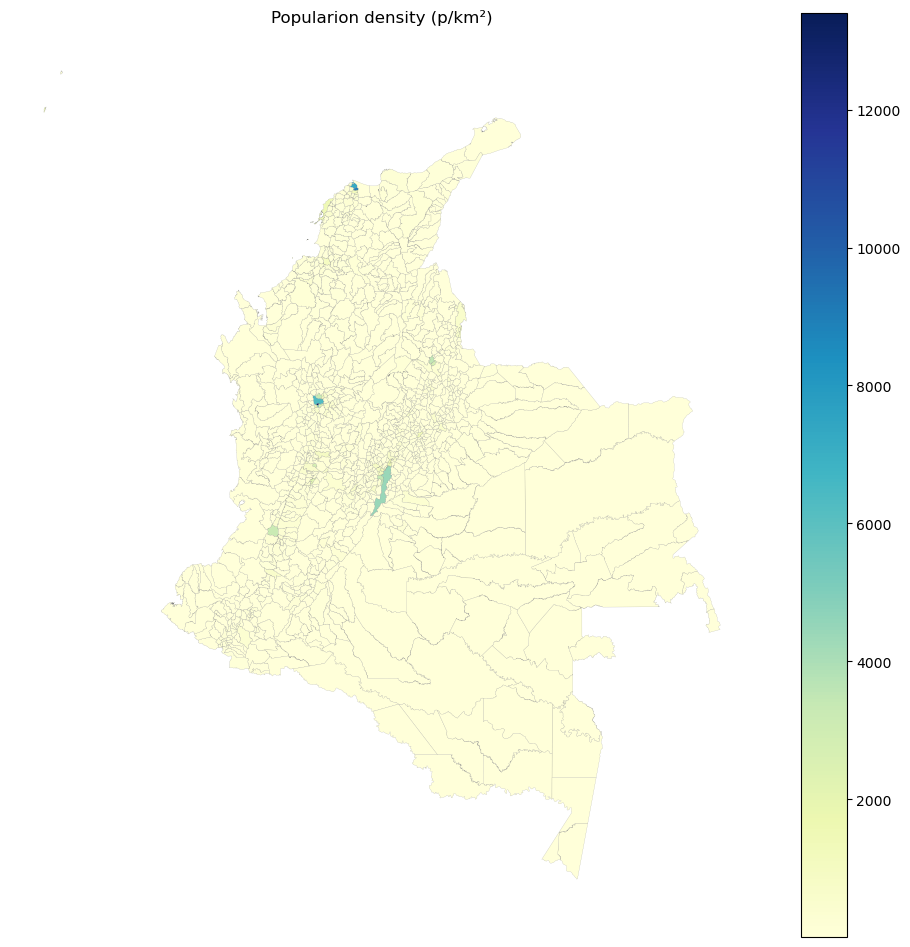

In [8]:
ax = muni.plot(column='pop_density_p_km2', cmap='YlGnBu', figsize=(12,12),
                     legend=True, edgecolor='grey', linewidth=0.1)
ax.set_title('Popularion density (p/km²)')
ax.set_axis_off()
plt.show()

In [9]:
# Filtrar datos de diferentes, extraer un subconjunto que cumpla condición como "subset -> >20 & <42 
# where, select, isin, df[df[]] -> loc  -> iloc (para cuando no se conoce el nombre de la columba, se llama por la posición numérica, se usa en numpy) == select no se puede usar, pero between sí.

# where

subset_1 = muni.where((muni['pop_density_p_km2'] > 4000) & (muni['pop_density_p_km2'] < 8000)).dropna() # No trae valores vacíos de df, sin él pone NA a todo lo que no cumple.
#print(subset_1[:,2])
print(subset_1)

# isin
subset_2 = muni[muni['pop_density_p_km2'].isin([4000, 8000])]
subset_2['pop_density_p_km2'].unique

# df[df[]]

subset_3 = muni[(muni['pop_density_p_km2'] > 4000) & (muni['pop_density_p_km2'] < 8000)]
subset_3.head()

# Usando between

subset_4 = muni[muni['pop_density_p_km2'].between(4000, 8000)]
subset_4['pop_density_p_km2'].unique()
subset_4.head()

     DPTO_CCDGO MPIO_CCDGO    MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
282          05        001      MEDELLÍN       5001   2018.0  3.748306e+08   
466          08        001  BARRANQUILLA       8001   2018.0  1.542021e+08   
908          11        001  BOGOTÁ, D.C.      11001   2018.0  1.622853e+09   
1120         05        631      SABANETA       5631   2018.0  1.583532e+07   

        LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  STP51_POST  \
282    6.257590 -75.611031    985003.0        0.0  ...     82299.0   
466   10.981521 -74.827715    375903.0        0.0  ...     32967.0   
908    4.316108 -74.181073   2737495.0        0.0  ...    416430.0   
1120   6.138305 -75.608806     37843.0        0.0  ...      6577.0   

      STP51_13_E  STP51_99_E  Shape_Leng  Shape_Area  Codigo_Mun  \
282      54515.0     35524.0    1.032922    0.030607      5001.0   
466      22655.0     15819.0    0.814371    0.012753      8001.0   
908     111390.0    161781.0    3.760453    0.132208  

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,STP51_POST,STP51_13_E,STP51_99_E,Shape_Leng,Shape_Area,Codigo_Mun,geometry,area_km2,perim_km,pop_density_p_km2
282,05,001,MEDELLÍN,5001,2018,3.748306e+08,6.257590,-75.611031,985003.0,0.0,...,82299.0,54515.0,35524.0,1.032922,0.030607,5001,"POLYGON ((823819.219 1196824.559, 823829.886 1...",374.830625,114.306923,6329.071968
466,08,001,BARRANQUILLA,8001,2018,1.542021e+08,10.981521,-74.827715,375903.0,0.0,...,32967.0,22655.0,15819.0,0.814371,0.012753,8001,"POLYGON ((915660.54 1719159.135, 915668.936 17...",154.202079,89.532753,7263.864451
908,11,001,"BOGOTÁ, D.C.",11001,2018,1.622853e+09,4.316108,-74.181073,2737495.0,0.0,...,416430.0,111390.0,161781.0,3.760453,0.132208,11001,"POLYGON ((1000367.81 1026577.849, 1000387.771 ...",1622.852605,416.459255,4425.213343
1120,05,631,SABANETA,5631,2018,1.583532e+07,6.138305,-75.608806,37843.0,0.0,...,6577.0,1124.0,1035.0,0.172905,0.001293,5631,"POLYGON ((831074.846 1172630.978, 831079.949 1...",15.835319,19.136713,5165.478497


### 4.  Spatial predicates  

We can test spatial relationships such as *contains* and *intersects*.  
The cell below creates a Shapely `Point` for Bolívar Square (Bogotá) in EPSG 4326, reprojects it to EPSG 3116, and finds the municipality that **contains** it.

In [11]:
from shapely.geometry import Point
bolivar = gpd.GeoSeries(
    # Formato WKT
    [Point(-74.0760, 4.5981)], crs=4326).to_crs(3116)

mask = muni.contains(bolivar.iloc[0])
muni.loc[mask, ['MPIO_CNMBR', 'MPIO_CDPMP']]

,MPIO_CNMBR,MPIO_CDPMP
908,"BOGOTÁ, D.C.",11001


### 4.1.  Buffering & intersection  

The next cell builds a **10 km buffer** around Bolívar Square and selects municipalities that intersect that buffer, then plots the result.

- **`.buffer(10_000)`**: Creates a buffer zone of 10,000 metres (10 km) around each geometry in the `bolivar` GeoDataFrame. This results in a new geometry representing the area within 10 km of `bolivar`.

- **`.union_all()`**: Merges all geometries in the buffer into a single, unified geometry. This is necessary to ensure that spatial operations are applied to the entire buffer area as one object.

- **`muni.intersects(...)`**: Performs a spatial comparison between each municipality in `muni` and the unified buffer. Returns `True` if the geometries touch or overlap, and `False` otherwise.

- **`muni[...]`**: This is a filtering operation. Only those rows in `muni` where the `.intersects()` condition is `True` are selected and stored in `sel`.

- **`.plot(...)`**: Visualises the selected municipalities using light coral fill and black outlines. The buffer boundary is then overlaid using a navy colour for visual distinction.

- **`gpd.GeoSeries(...).boundary`**: Converts the buffer geometry to a GeoSeries and extracts its boundary (outline only) for plotting purposes.

- **`ax.set_axis_off()`**: Removes the axis from the plot to create a cleaner map visual.

- **`plt.show()`**: Displays the final plot.

This analysis allows us to visualise which municipalities fall within a certain distance of the target region (`bolivar`) — a common GIS task when performing proximity analysis.


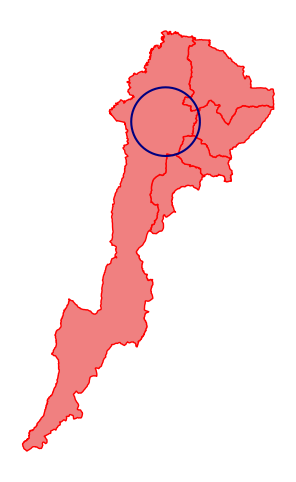

In [12]:
buffer_10km = bolivar.buffer(10_000)  # metres
sel = muni[muni.intersects(buffer_10km.union_all())]

ax = sel.plot(facecolor='lightcoral', edgecolor='red', figsize=(6,6))
gpd.GeoSeries(buffer_10km).boundary.plot(ax=ax, color='navy')
ax.set_axis_off()
plt.show()


### 4.2.  Overlay operations  

`geopandas.overlay()` performs geometric set operations.  

In the next cell (**`gpd.overlay(sel, …, how='intersection')`**)
   * `sel` is the subset of municipalities that intersect the 10 km buffer around Bolívar Square.  
   * We build a one-column GeoDataFrame from `buffer_10km` and ask GeoPandas to compute the *intersection*.  
   * The output `clipped` contains **only the portions of those municipalities lying inside the buffer**—all other parts are removed.

The you plot the result 
   * `edgecolor='darkgreen', facecolor='none'` draws hollow polygons with dark-green borders, helping you see the clipped shapes without obscuring any background.  
   * `figsize=(5, 5)` keeps the graphic compact.  
   * `plt.show()` displays the figure.

> This pattern is widely used for masking layers to a study area: you keep just the geometry relevant to your analysis while preserving all attribute columns.


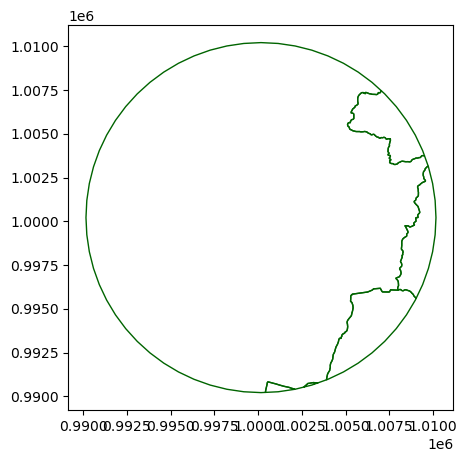

In [13]:
clipped = gpd.overlay(sel, gpd.GeoDataFrame(geometry=buffer_10km),
                        how='intersection')
clipped.plot(edgecolor='darkgreen', facecolor='none', figsize=(5,5))
plt.show()

### 4.3  Dissolving municipalities into departments  

Aggregating multiple geometries with `.dissolve()` produces multi‑polygon departments and summarises numeric attributes. 
The following cell rolls up the municipal layer to the **department** level:

* **`muni.dissolve(by='DPTO_CCDGO', …)`**  
  Groups polygons by the two-digit department code `DPTO_CCDGO` and **fuses** them into larger multi-polygons.
* **`aggfunc={'area_km2': 'sum', 'STP27_PERS': 'sum'}`**  
  Sums municipal area and population while dissolving, producing department-wide totals.
* **Population density** – we then derive `pop_density` by dividing department population by department area.

The returned GeoDataFrame `dptos` therefore contains **one row per department** with fresh attributes ready for mapping or further analysis.


In [14]:
dptos = muni.dissolve(
    by='DPTO_CCDGO',
    aggfunc={'area_km2': 'sum', 'STP27_PERS': 'sum'}
)
dptos['pop_density'] = dptos['STP27_PERS'] / dptos['area_km2']
dptos

,geometry,area_km2,STP27_PERS,pop_density
DPTO_CCDGO,,,,
05,"POLYGON ((797311.153 1098218.268, 797296.716 1...",62804.708984,5974788.0,95.132803
08,"POLYGON ((913344.747 1635351.841, 913045.46 16...",3315.752105,2342265.0,706.405342
11,"POLYGON ((1000367.81 1026577.849, 1000387.771 ...",1622.852605,7181469.0,4425.213343
13,"MULTIPOLYGON (((769570.062 1530592.901, 769491...",26719.196397,1909460.0,71.463976
15,"POLYGON ((1069888.018 1032371.02, 1069844.914 ...",23138.048132,1135698.0,49.083570
17,"POLYGON ((860203.953 1049730.409, 860229.936 1...",7425.221672,923472.0,124.369620
18,"POLYGON ((843380.042 578391.001, 843334.602 57...",90103.008160,359602.0,3.991010
19,"POLYGON ((671667.322 681452.757, 671665.984 68...",31242.914795,1243503.0,39.801120
20,"POLYGON ((1076018.853 1388756.407, 1076065.315...",22562.344407,1098577.0,48.690729


#### Now it’s your turn #2 – Spatial data exercises  

1. Select and map **three** municipalities whose centroid lies west of 75° W longitude.  
2. Compute the *perimeter : area* ratio for every municipality and identify the most compact one.  
3. Draw a 10 km buffer around a municipality of your choice and highlight intersecting neighbours.
4. “Calculate and map the percentage of dwellings with internet


,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,geometry,area_km2,perim_km,pop_density_p_km2,centroide,centr_4326,centroid_x,centroid_y,porc_viv_int,area_class
628,88,001,SAN ANDRÉS,88001,2018,2.713979e+07,12.543179,-81.717572,22801.0,0.0,...,"MULTIPOLYGON (((170560.581 1891857.33, 170569....",27.139793,42.876464,1612.171471,POINT (167427.736 1891048.639),POINT (-81.71757 12.54317),-81.717573,12.543175,23.462359,Q1
629,88,564,PROVIDENCIA,88564,2018,2.228446e+07,13.353250,-81.373939,4162.0,0.0,...,"MULTIPOLYGON (((208809.567 1983832.853, 208815...",22.284459,32.931650,203.953800,POINT (207655.092 1980257.395),POINT (-81.37394 13.35325),-81.373940,13.353249,24.139651,Q1
435,52,835,SAN ANDRÉS DE TUMACO,52835,2018,3.611511e+09,1.636103,-78.613905,52843.0,14037.0,...,"MULTIPOLYGON (((463848.633 659319.866, 463849....",3611.510834,718.515934,38.236352,POINT (494678.985 673249.695),POINT (-78.61395 1.63609),-78.613951,1.636091,6.813923,Q4


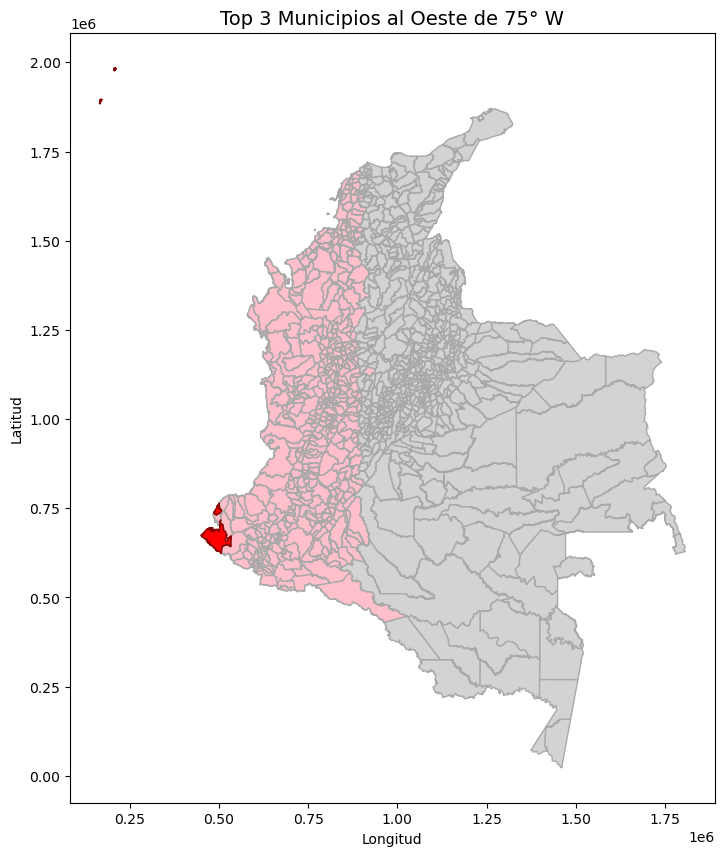

In [43]:
# 1. Seleccionando los 3 municipios. 
#Calcular centroide
muni['centroide'] = muni.centroid

#Convertir centroide en coordenadas 4326 en otra columna
muni['centr_4326'] = muni['centroide'].to_crs(4326)

# Extraer coordenadas x e y:
muni['centroid_x'] = muni['centr_4326'].apply(lambda p: p.x)
muni['centroid_y'] = muni['centr_4326'].apply(lambda p: p.y)

# Selección de municipios al oeste de 75
muni_west = muni[muni['centroid_x'] < -75]

# Nuvo dataframe con 3 municipios mas cercnos al oeste
#three_muni_west = muni_west.sort_values(by='centroide', key=lambda x: x.x).head(3)
#three_muni_west = muni_west.sort_values(by=muni_west['centroid_x']).head(3)
three_muni_west = muni_west.sort_values(by='centroid_x').head(3)

# Ploter
fig, ax = plt.subplots(figsize=(10, 10))

muni.plot(ax=ax, facecolor='lightgray', edgecolor='darkgray')
muni_west.plot(ax=ax, color='pink', edgecolor='darkgray')
three_muni_west.plot(ax=ax, color='red', edgecolor='darkred')

ax.set_title('Top 3 Municipios al Oeste de 75° W', fontsize=14)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

three_muni_west

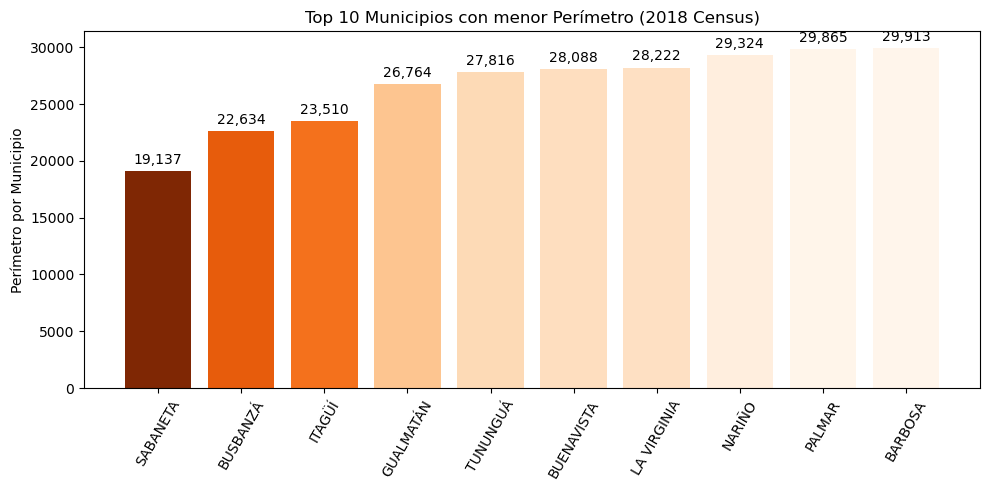

In [94]:
# 2. Computar el perímetro de todos los municipios
muni['perimetro'] = muni.geometry.length

# Nuevo gdf con perímetros ordenados de forma ascendente
muni_perim_asc = muni[[ 'MPIO_CNMBR', 'perimetro']].sort_values('perimetro', ascending=True).head(10)

# Crar figura para representar en un bar
fig, ax = plt.subplots(figsize=(10, 5))

# Normalizar datos de perimetro
norm_dens = Normalize(vmin=min(muni_perim_asc['perimetro']), vmax=max(muni_perim_asc['perimetro']))

cmap = plt.get_cmap('Oranges_r')

barsplot = ax.bar(muni_perim_asc['MPIO_CNMBR'][::1], muni_perim_asc['perimetro'][::1], color=cmap(norm_dens(muni_perim_asc['perimetro'])))

# Etiquetas de valores en las barras
ax.bar_label(barsplot, labels=[f'{x:,.0f}' for x in muni_perim_asc['perimetro']], padding=3)

# Título y etiqueta de y
ax.set_ylabel('Perímetro por Municipio')
ax.set_title('Top 10 Municipios con menor Perímetro (2018 Census)')

plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


     DPTO_CCDGO MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
1072         73        168  CHAPARRAL      73168     2018  2.102063e+09   

       LATITUD   LONGITUD  STCTNENCUE  STP3_1_SI  ...  Shape_Area  Codigo_Mun  \
1072  3.743693 -75.589866     24131.0        0.0  ...    0.171009       73168   

                                               geometry     area_km2  \
1072  POLYGON ((814906.058 938693.114, 814944.085 93...  2102.063236   

        perim_km  pop_density_p_km2                      centroide  \
1072  285.926383          20.834292  POINT (831981.914 905875.317)   

                    centr_4326  centroid_x  centroid_y  
1072  POINT (-75.58987 3.7437)  -75.589871    3.743701  

[1 rows x 99 columns]


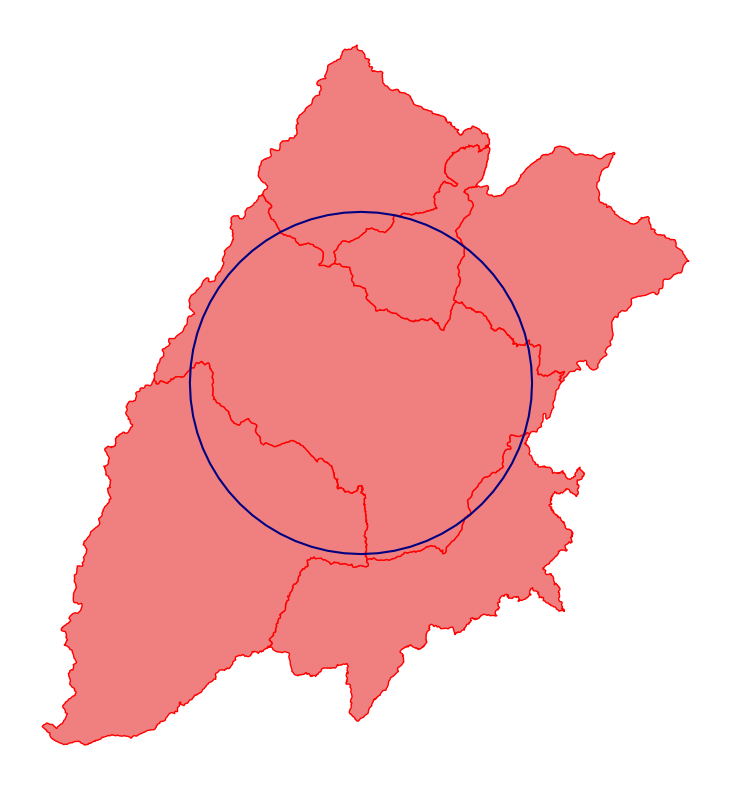

In [16]:
# 3. Dibujando una zona de influencia alrededor de Chaparral

chaparral = muni[muni['MPIO_CNMBR'] == "CHAPARRAL"]
print(chaparral)

# Creando buffer

buffer_chapa_10km = chaparral['centroide'].buffer(30_000)
sell = muni[muni.intersects(buffer_chapa_10km.union_all())]

ax = sell.plot(facecolor='lightcoral', edgecolor='red', figsize=(10,10))
gpd.GeoSeries(buffer_chapa_10km).boundary.plot(ax=ax, color='navy')
ax.set_axis_off()
plt.show()


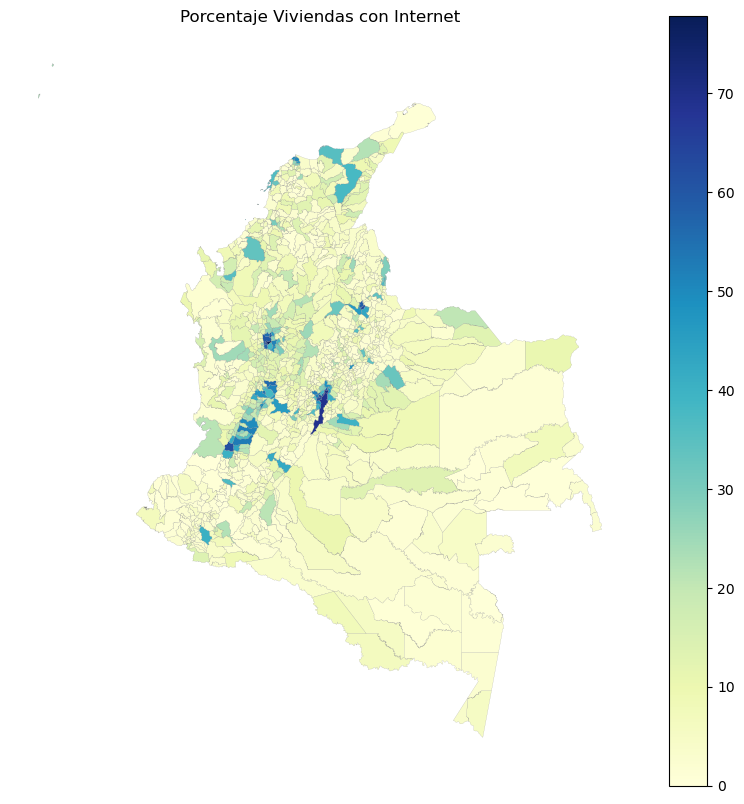

In [17]:
# “Calculate and map the percentage of dwellings with internet

# 4. Calclando el porcentaje de viviendas con internet
    # STP19_INT1 Conteo de viviendas con internet, STP19_INT2 Conteo de viviendas sin internet, STVIVIENDA Conteo de viviendas

muni ['porc_viv_int'] = muni ['STP19_INT1']/muni ['STVIVIENDA'] * 100

# Mapeando el porcentaje de viviendas con internet


ax = muni.plot(column='porc_viv_int', cmap='YlGnBu', figsize=(10,10),
                     legend=True, edgecolor='grey', linewidth=0.1)
ax.set_title('Porcentaje Viviendas con Internet')
ax.set_axis_off()
plt.show()


## 5  Attribute operations  
(If yo uwant to go further check **[This LINK](https://py.geocompx.org/02-attribute-operations.html)**)  
All 80 census variables are numeric counts, so they behave like ordinary pandas columns: you can add, divide, group, and classify them. See the manual for categorical meanings.


## 5.1  Column selection and boolean indexing  

The cell below keeps only selected columns and filters municipalities larger than 1 000 km².

In [18]:
core = muni[['DPTO_CCDGO', 'MPIO_CNMBR', 'area_km2']]
large = core[core.area_km2 > 1000].sort_values('area_km2', ascending=False)
large.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2
188,99,CUMARIBO,65597.212445
12,18,SOLANO,42312.783610
187,99,LA PRIMAVERA,18362.896666
11,18,SAN VICENTE DEL CAGUÁN,17464.634368
937,50,PUERTO GAITÁN,17250.083167


Show municipalities where < 30 % of dwellings have internet.

In [19]:
poor_net = muni[
    (muni['STP19_INT1'] / muni['STVIVIENDA']) < 0.3
][['MPIO_CNMBR', 'DPTO_CCDGO']]
poor_net.head()


,MPIO_CNMBR,DPTO_CCDGO
0,FLORENCIA,18
1,ALBANIA,18
2,BELÉN DE LOS ANDAQUÍES,18
3,EL DONCELLO,18
4,EL PAUJÍL,18


## 5.2  Creating new attributes  

We next classify municipal area into quartiles using `pd.qcut()`. Quantile classification is a quick way to create balanced size classes:

* **`pd.qcut(muni.area_km2, 4, labels=['Q1','Q2','Q3','Q4'])`**  
  Splits the `area_km2` distribution into four equal-frequency bins (quartiles) and labels them Q1–Q4.
* **`muni['area_class'].value_counts()`**  
  Shows how many municipalities fall into each quartile—useful for sanity-checking the split.

In [20]:
muni['area_class'] = pd.qcut(muni.area_km2, 4,
                             labels=['Q1','Q2','Q3','Q4'])
muni['area_class'].value_counts()

area_class
Q1    281
Q4    281
Q2    280
Q3    280
Name: count, dtype: int64

## 5.3  Grouping and summarising  


To discover which departments cover the largest territory we:

1. **Group by `DPTO_CCDGO`** – one record per department.
2. **Sum `area_km2`** – aggregate municipal areas.
3. **Sort descending** – most extensive departments first.
4. **Display the top five** – quick headline figures.


In [21]:
area_by_dpto = muni.groupby('DPTO_CCDGO')['area_km2'].sum()                      .sort_values(ascending=False)
area_by_dpto.head()

DPTO_CCDGO
91    109497.053810
99    100063.370746
18     90103.008160
50     85527.289734
94     71289.354694
Name: area_km2, dtype: float64

Computes the departmental share of households in ethnic territories.

In [22]:
# STP3_1_SI Cantidad de encuestas en territorio étnico, STCTNENCUE Cantidad de Encuestas CNPV 2018 
ethnic_share = (
    muni.groupby('DPTO_CCDGO')['STP3_1_SI'].sum()
    / muni.groupby('DPTO_CCDGO')['STCTNENCUE'].sum()
    * 100
)
ethnic_share.sort_values(ascending=False).head()


DPTO_CCDGO
97    54.095904
27    34.801234
94    28.141512
44    27.811409
99    27.573751
dtype: float64

## 5.4  Joining a non‑spatial table  

We load the agricultural CSV, rename the municipality code column, and perform a **left join** onto the GeoDataFrame. This enriches the spatial layer with production information.


| Step | Action |
|------|--------|
 **Zero-pad codes to 5 digits** | Convert both key columns (`MPIO` and `MPIO_CDPMP`) to string type using `astype(str)`, then apply `.zfill(5)` to ensure each code has exactly five digits (e.g. `05266` instead of `5266`). This standardisation is critical for successful joins, as leading zeros are otherwise lost in numeric formats. |
| **Merge** | Use `muni.merge(...)` with `how='left'` to preserve all rows in the `muni` spatial dataset, even if no matching EVA record exists. The parameters `left_on='MPIO_CDPMP'` and `right_on='MPIO'` specify the respective join keys. |
| **Diagnostics** | Setting `indicator=True` adds a new column called `_merge`, which indicates whether each row matched on both sides (`both`), only in the left (`left_only`), or only in the right (`right_only`). The `validate='one_to_many'` argument checks that each municipality in `muni` links to at most one match in `eva`, helping catch unexpected duplicates. |
| **Collision control** | The `suffixes=('', '_eva')` argument avoids unintentional overwriting of columns with identical names in both datasets by appending `_eva` to the conflicting column names from the EVA table. |

After the join, `muni_eva` carries all original municipal attributes **plus** EVA variables, ready for mapping yields, harvested area, or production volumes.


In [23]:
#eva = pd.read_csv(csv_path, encoding='latin1')

#TRy also this one
eva = pd.read_csv(csv_path, encoding='utf-8')

eva = eva.rename(columns={'CÓD. MUN.': 'MPIO'})
print(eva.head())
eva['MPIO'] = eva['MPIO'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)

muni_eva = muni.merge(
    eva,
    how='left',                 # left = muni
    left_on='MPIO_CDPMP',       # key in en muni
    right_on='MPIO',            # key in eva
    indicator=True,             # create  column _merge
    validate='one_to_many',      # or 'one_to_many' check all the possibilities
    suffixes=('', '_eva')       # evita colisiones de nombre
)
print(muni_eva['_merge'].value_counts())
print(muni_eva.columns.tolist())


   CÓD. \nDEP.        DEPARTAMENTO   MPIO   MUNICIPIO GRUPO \nDE CULTIVO  \
0           15              BOYACA  15114    BUSBANZA         HORTALIZAS   
1           25        CUNDINAMARCA  25754      SOACHA         HORTALIZAS   
2           25        CUNDINAMARCA  25214        COTA         HORTALIZAS   
3           54  NORTE DE SANTANDER  54405  LOS PATIOS         HORTALIZAS   
4           54  NORTE DE SANTANDER  54518    PAMPLONA         HORTALIZAS   

  SUBGRUPO \nDE CULTIVO CULTIVO DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO  \
0                ACELGA  ACELGA                                        ACELGA   
1                ACELGA  ACELGA                                        ACELGA   
2                ACELGA  ACELGA                                        ACELGA   
3                ACELGA  ACELGA                                        ACELGA   
4                ACELGA  ACELGA                                        ACELGA   

    AÑO PERIODO  Área Sembrada\n(ha)  Área Cosechada\n(h

The next cell derives **rice yield** (t ha⁻¹) and maps it using a quantile scheme and the `PuRd` colour map. 
What happens if you use the column PERIODO instead of AÑO?

Rows kept: 343
                MPIO_CNMBR CULTIVO     AÑO
29               FLORENCIA   ARROZ  2018.0
643              EL PAUJÍL   ARROZ  2018.0
758           LA MONTAÑITA   ARROZ  2018.0
958                  MILÁN   ARROZ  2018.0
1466  CARTAGENA DEL CHAIRÁ   ARROZ  2018.0


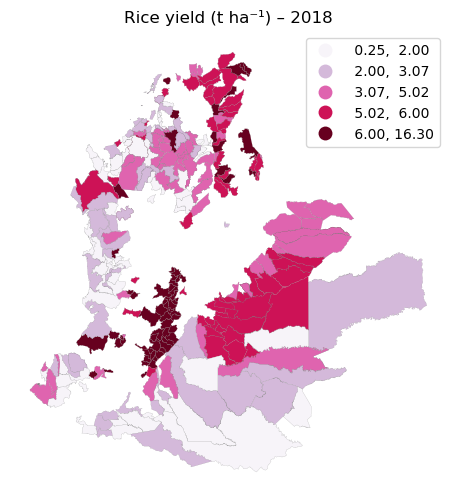

In [30]:
# --- Parameters -------------------------------------------------------------
selected_year = 2018          # <- choose the year you want to visualise
crop_name     = 'ARROZ'       # <- crop label exactly as it appears in EVA

# --- Subset for crop and year ----------------------------------------------
# 1. Keep rows matching the chosen crop
# 2. Keep rows for the chosen year
rice = (
    muni_eva
    .query("CULTIVO == @crop_name and AÑO == @selected_year")  # edit column name if needed
    #.query('CULTIVO == "ACELGA" and AÑO == 2018')  # edit column name if needed
    .copy()
)

# Sanity-check: does the subset look right?
print(f"Rows kept: {len(rice):,}")
print(rice[['MPIO_CNMBR', 'CULTIVO', 'AÑO']].head())

# --- Calculate yield --------------------------------------------------------
rice['yield_t_ha'] = (
    rice['Producción\n(t)'] / rice['Área Sembrada\n(ha)']
)

# Drop any rows with missing yield
rice_map = rice.dropna(subset=['yield_t_ha'])

# --- Plot -------------------------------------------------------------------
ax = rice_map.plot(
    column='yield_t_ha',
    scheme='Quantiles', k=5,
    cmap='PuRd', legend=True,
    figsize=(6, 6),
    edgecolor='grey', linewidth=0.1
)
ax.set_title(f'Rice yield (t ha⁻¹) – {selected_year}')
ax.set_axis_off()
plt.show()


#### Now it’s your turn #3 – Attribute drills  

1. Create a bar chart of the **top‑10** municipalities by *maize* production.  
2. Map coffee yield and describe spatial trends you observe.  
3. Calculate the mean municipal area per *ZONA* category.
4. Map the proportion of dwellings connected to gas: STP19_GAS1 / STVIVIENDA.
5. Compute the sex ratio (STP32_1_SE / STP32_2_SE) for every municipality and discuss spatial patterns.


In [54]:
print(muni_eva['MPIO_CDPMP'].unique().size)

1122


        MPIO_CNMBR  Producción\n(t)
625  PUERTO GAITÁN     29649.054054
288        ESPINAL     18630.571429
219       CUMARIBO     12563.115385
630   PUERTO LÓPEZ     10468.116279
208        COTORRA      9454.947368


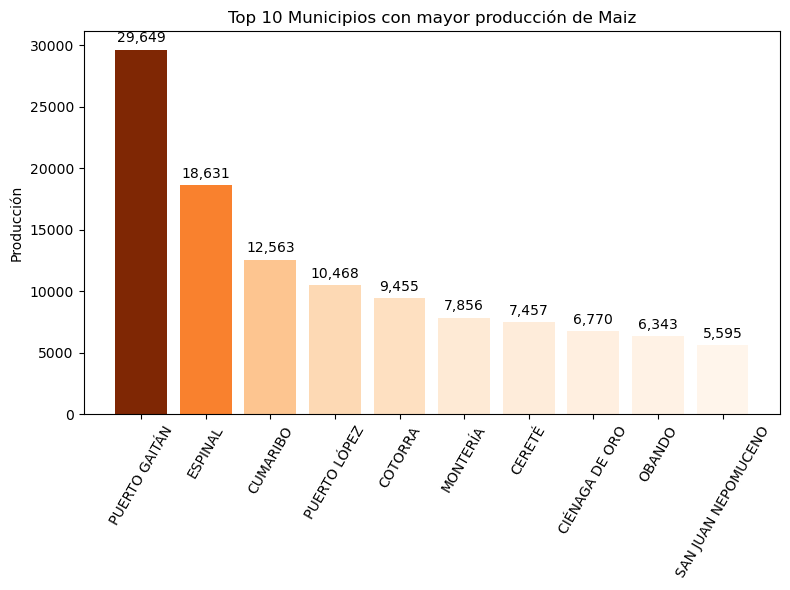

In [59]:
# Creando un bar chart de Top 10 municipios por producción de Maíz.

# Ordenando 

procc_maiz = muni_eva.loc[muni_eva['CULTIVO'] == 'MAIZ', ['MPIO_CNMBR', 'Producción\n(t)']] #ChatGPT


#procc_maiz = muni_eva[muni_eva['MPIO_CNMBR', 'Producción\n(t)']['CULTIVO'] == 'MAIZ'] mio

top_procc_desc = procc_maiz[['MPIO_CNMBR', 'Producción\n(t)']].groupby('MPIO_CNMBR', as_index=False).mean('Producción\n(t)').sort_values('Producción\n(t)', ascending=False).head(10)
print(top_procc_desc.head())
# Crar figura para representar en un bar
fig, ax = plt.subplots(figsize=(8, 6))

# Normalizar datos de perimetro
norm_procc = Normalize(vmin=min(top_procc_desc['Producción\n(t)']), vmax=max(top_procc_desc['Producción\n(t)']))

cmap = plt.get_cmap('Oranges')

barsplot_procc = ax.bar(top_procc_desc['MPIO_CNMBR'][::1], top_procc_desc['Producción\n(t)'][::1], color=cmap(norm_procc(top_procc_desc['Producción\n(t)'])))

# Etiquetas de valores en las barras
ax.bar_label(barsplot_procc, labels=[f'{x:,.0f}' for x in top_procc_desc['Producción\n(t)']], padding=3)

# Título y etiqueta de y
ax.set_ylabel('Producción')
ax.set_title('Top 10 Municipios con mayor producción de Maiz')

plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


        MPIO_CNMBR  Producción\n(t)
601        PALMIRA     91465.936293
270     EL CERRITO     72400.311111
137     CANDELARIA     65630.531729
680  PUERTO TEJADA     56078.456140
913          TAUSA     42674.253968


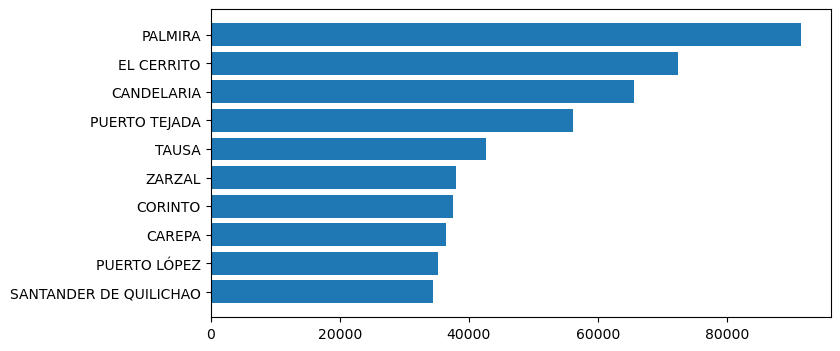

"\nfig, ax = plt.subplots(figsize=(10, 6))\nax.barh(top_pop['MPIO_CNMBR'][::-1], top_pop['STP27_PERS'][::-1])\nax.set_xlabel('Population (persons)')\nax.set_title('Top 20 most populous municipalities (2018 Census)')\nplt.tight_layout()\nplt.show()"

In [39]:
# Ordenando 

top_procc_desc = muni_eva[['MPIO_CNMBR', 'Producción\n(t)']].groupby('MPIO_CNMBR', as_index=False).mean().sort_values('Producción\n(t)', ascending=False).head(10)
print(top_procc_desc.head())
# Crar figura para representar en un bar
fig, ax = plt.subplots(figsize=(8, 4))

# Normalizar datos de perimetro
norm_procc = Normalize(vmin=min(top_procc_desc['Producción\n(t)']), vmax=max(top_procc_desc['Producción\n(t)']))

cmap = plt.get_cmap('Oranges')

#barsplot_procc = ax.bar(top_procc_desc['MPIO_CNMBR'][::-1], top_procc_desc['Producción\n(t)'][::-1], color=cmap(norm_procc(top_procc_desc['Producción\n(t)'])))
ax.barh(top_procc_desc['MPIO_CNMBR'][::-1], top_procc_desc['Producción\n(t)'][::-1])
plt.show()
'''
# Etiquetas de valores en las barras
ax.bar_label(barsplot_procc, labels=[f'{x:,.0f}' for x in top_procc_desc['Producción\n(t)']], padding=3)

# Título y etiqueta de y
ax.set_ylabel('Producción')
ax.set_title('Top 10 Municipios con mayor producción de Maiz')

plt.xticks(rotation=60)
plt.tight_layout()
plt.show()'''

# Ejemplo
'''
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_pop['MPIO_CNMBR'][::-1], top_pop['STP27_PERS'][::-1])
ax.set_xlabel('Population (persons)')
ax.set_title('Top 20 most populous municipalities (2018 Census)')
plt.tight_layout()
plt.show()'''


---

## 6.  Visualisation best practice  

Choose an equal‑area CRS, add clear legends, north arrows, and cite data sources.  
The next cell reprojects the rice yield map to **Web Mercator (EPSG 3857)**, adds a basemap, and annotates the source line.

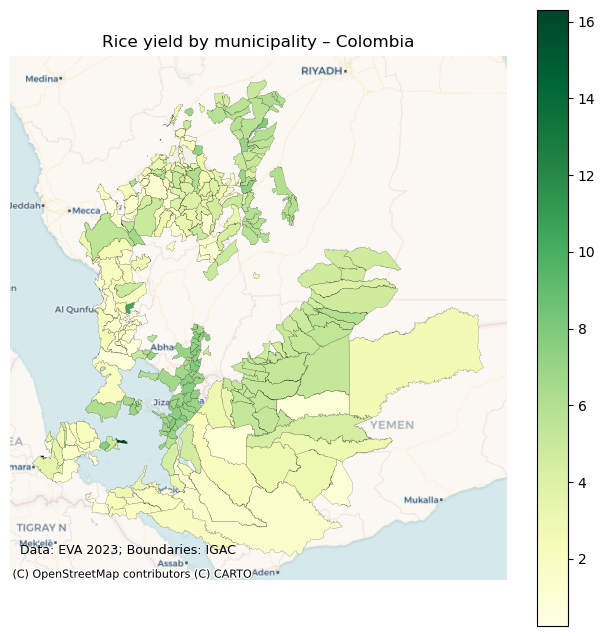

In [146]:
ax = rice_map.to_crs(9377).plot(column='yield_t_ha', cmap='YlGn',
                     figsize=(8,8), edgecolor='black', linewidth=0.1, legend=True)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_title('Rice yield by municipality – Colombia')
ax.annotate('Data: EVA 2023; Boundaries: IGAC', xy=(0.02, 0.05),
            xycoords='axes fraction', fontsize=9)
ax.set_axis_off()
plt.show()

#### Now it’s your turn #4 – Cartography challenge  

* Re‑project to the CRS 4326.  
* Add grey department boundaries on top.  
* Compose a concise caption in British English that explains what the map shows.  


## 📚 7. project – Bringing it all together  
*(revised to reflect municipal-level production totals)*

### Project title  
**“Are Colombia’s meteorological stations well-placed to support its main crop-producing municipalities?”**

### Context  
The EVA dataset provides **municipal totals** of sown area, production and yield—there is **no field-boundary geometry**. Therefore every agricultural metric is attached to the municipality polygon (or its centroid). Your analysis must respect that spatial resolution.

### Objective  
Evaluate how effectively the national meteorological-station network covers the municipalities that account for the bulk of crop production.

### Data  
* `municipios_colombia.shp` – municipal boundaries, EPSG 3116  
* `Evaluaciones_Agropecuarias_Municipales_EVA.csv` – yearly production totals per municipality  
* `Catalogo_Estaciones_IDEAM.csv` – latitude/longitude of meteorological stations (convert to EPSG 3116)



### Tasks  

| # | Task | Key skills revisited |
|---|------|----------------------|
| 1 | **Load & harmonise**  <br>• Read all three files.  <br>• Zero-pad municipal codes and ensure all geometries are in EPSG 3116. | File I/O, CRS handling |
| 2 | **Crop–year focus**  <br>• Choose *one* crop (e.g. rice) and *one* recent year.  <br>• Compute municipal **production**, **sown area**, **yield (t ha⁻¹)**. | Attribute join, filtering, derived variables |
| 3 | **Top-quartile producers**  <br>• Flag municipalities in the **upper quartile of production**.  <br>• Produce both a map and a table (top 20) of those municipalities. | Quantile classification, choropleths, tables |
| 4 | **Station counts**  <br>• Convert the station CSV to a `GeoDataFrame`.  <br>• **Spatial join** each station to its department (`gpd.sjoin`).  <br>• Generate a table: *number of stations per department*.  <br>• Create:  <br> a) a choropleth map of station counts by department,  <br> b) a horizontal bar chart of the same counts (descending order). | Point–polygon spatial join, aggregation, mapping, tabular visualisation |
| 5 | **Production vs coverage**  <br>• Dissolve municipalities to departments (summing crop production).  <br>• Join the station-count table to this dissolved layer.  <br>• Produce a scatter plot of *departmental production* vs *station count*; label the four extremal cases (high-production/low-coverage, etc.). | Dissolve with custom `aggfunc`, joins, scatter plots |
| 6 | **Short commentary** (max 120 words)  <br>Briefly comment on any mismatch between production volume and station coverage; suggest two departments that might benefit from additional stations. | Concise interpretation |

### Deliverables  

1. A single, well-structured notebook (`.ipynb`) containing code, markdown explanations, a minimum of **two maps** (Tasks 3 & 4) and **two charts** (bar + scatter).  
2. Any image exports stored in a `/figures` folder.

### Assessment rubric (18 points)  

### Marking rubric – Capstone project

| Criterion (max 10 pts each) | Excellent (10) | Good (8) | Satisfactory (6) | Needs improvement (0-5) |
|----------------------------|---------------|----------|------------------|-------------------------|
| **1. Data preparation & CRS**<br>*Task 1* | All three datasets loaded correctly; municipal codes zero-padded; every layer re-projected to EPSG 3116 and the CRS explicitly documented. | Minor slip (e.g. one CRS printout missing) but data still correct. | Significant omissions (e.g. no CRS check) yet analysis still runs. | Wrong CRS or unpadded codes cause spatial mismatch / results invalid. |
| **2. Crop–year analysis**<br>*Task 2* | Production, sown area and yield calculated flawlessly for chosen crop-year; clear explanation of formulae. | One calculation or explanation unclear but outcomes largely correct. | Calculations patchy or inconsistently labelled. | Crop–year subset or yield calculation incorrect / absent. |
| **3. Spatial joins & aggregation**<br>*Tasks 3–5* | Station-to-department join, department dissolve and station counts executed with correct predicates and `aggfunc`; outputs fully validated (row counts, null checks). | Logical joins/aggregations but validation limited. | Joins partly correct (e.g. wrong predicate) yet results broadly plausible. | Joins/aggregations flawed or missing → results misleading. |
| **4. Visualisation quality**<br>*Maps × 2, bar, scatter* | Maps use appropriate colour ramps, legends, titles; bar & scatter charts clearly labelled; figures exported to `/figures`. | Visuals intelligible but minor cosmetic issues (legend size, axis units). | Visuals produced but cluttered or lacking legends/titles. | Required visuals missing or unreadable. |
| **5. Code structure & documentation** | Notebook cleanly sectioned; functions or reusable blocks minimise repetition (DRY); markdown explains every step. | Mostly well-structured; a few redundant code blocks or sparse comments. | Long repetitive cells; key decisions undocumented. | Disorganised, little or no explanation, hard to follow. |

**Total: 50 points**



In [107]:
# You r script here 

